# Specific Company Debt

This notebook presents results for the specified companies:
- Lexicon Pharmaceuticals Inc (Ticker LXRX) CIK = 0001062822
- Amicus Therapeutics (Ticker FOLD) CIK = 0001178879
- Empire State Realty Trust (Ticker ESRT) CIK = 0001541401
- Wright Medical Group (Ticker WMGI) CIK = 0001492658
- Heritage Insurance Holdings (Ticker HRTG) CIK = 0001598665
- Cheasapeake Energy Corporation (Ticker CHK) CIK = 0000895126
- International Business Machines Corporation (Ticker IBM) CIK = 0000051143
- Apple Inc (Ticker AAPL) CIK = 0000320193
- Hovnanian Enterprises Inc (Ticker HOV) CIK = 0000357294
- Wyndham Destinations, Inc (Ticker WYND) CIK = 0001361658

Results for each company are presented below and covered in the following order:

1) plots for the extracted short term and long term debt across time are shown.  When a debt disclosure was extracted for the given quarter, the data point is highlighted in red.  

2) A data frame containing resolved debt fields is printed to console.

3) A data frame containing the extracted disclosure is printed to console.

One of the tasks I did not have sufficent time to complete was building a topic-modeling algorithim to further process the debt-disclosures.  Gensim and nltk are python libraries that can support this kind of task, and aid in relavent passage extraction and summarization.  I think given more time this could be an interesting area of study.  

As a final note, I want to mention that the task of extracting reliable debt levels from decades worth of filings that appear in multiple formats is a challenging one.  While, I think the applicable produced is a strong proof-of-concept, I want to be explicit about the possible sources of error and what could go wrong.

1) There are errors, inconsistencies, and missing data in the edgar system of record.  Additionally, occasionally daily index files are served out as zipped tar files.  This is a corner case that I elected not to handle in the current design and as a result there are some gaps in the debt information extracted.

2) The application can fail to extract any information from the filing.  This could be a result of the extraction strategies employed not being general enough to capture useful patterns of debt representation, or, it could be the result of a particular filer using particularly non-standard formating or reporting language.

3) Even when extraction succeeds, the raw results are further processed and resolved against standard gaap terms.  Occasionally, multiple extracted items will resolve to the same gaap field, and in this case, heuristics are used to select the "best" match.  It's likely that some useful extracted results are erronously filtered out during "entity-linkage" process.

4) After resolution, individual debt fields are populated and then aggregated into final short and long term debt numbers.  This process of "rolling up" subfields can again introduce error, especially if a piece of information has been incorrectly linked to a "parent" debt field.  

5) Finally, as touched upon else where, there is a unit-inconsistency betweendifferent filing types, with HTML and TEXT filings more likely to report numbers in 1000s.  In the results that follow i've done my best to account for unit-scaling, however, this is really something that should be built into the extraction process itself.

In [74]:
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  

pd.options.display.max_columns = 50

In [185]:
selectCIKs = [
    1062822,
    1178879,
    1541401,
    1492658,
    1598665,
    895126,
    51143,
    320193,
    357294,
    1361658
]

DATA_DIR = '/home/peter/citadel/edgarScraper/data'

def readDebtData(dataDir):

    dfs = []
    for year in range(1994, 2019):
        fileName = 'results_{}.csv'.format(year)
        filePath = os.path.join(dataDir, fileName)
        dfs.append(pd.read_csv(filePath))

    df = pd.concat(dfs)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.drop_duplicates(inplace=True)
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for c in [c for c in df.columns if df[c].dtype in numerics]:
        pass
        #df[c] = df[c].abs()
        
    # if a company submitted multiple 10-Qs within the same calendar month - take only the last one.  
    #df = df.set_index(['DATE', 'CIK', 'NAME'])
    df = df.groupby([pd.Grouper(key='DATE', freq='M'), 'CIK']).last()
    df = df.reset_index()

    return df

def readDisclosureData(dataDir):

    dfs = []
    for year in range(1994, 2019):
        fileName = 'disclosures_{}.csv'.format(year)
        filePath = os.path.join(dataDir, fileName)
        dfs.append(pd.read_csv(filePath))

    df = pd.concat(dfs)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.drop_duplicates(inplace=True)
    return df[~pd.isnull(df['TEXT'])]

debt = readDebtData(DATA_DIR)
disclosures = readDisclosureData(DATA_DIR)

In [160]:
def fixUnitScaling(df, scaleBy, threshold):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_cols = [c for c in df.columns if df[c].dtype in numerics]
    
    numericPiece = df.loc[
        df['EXTRACTCODE'].isin(['TEXT', 'HTML']),
        numeric_cols
    ] 
    
    scaledNumericPiece = numericPiece.where( numericPiece > threshold, other=numericPiece*scaleBy)
    
    df.loc[
        df['EXTRACTCODE'].isin(['TEXT', 'HTML']),
        numeric_cols
    ] = scaledNumericPiece
            
    return df

def getJoinedData(debtDf, disclosureDf, cik, fixScaling=False, scaleBy=1e3, threshold=1e6):
    
    _disclosureDf = disclosureDf[disclosureDf['CIK'] == cik].copy()
    _debtDf = debtDf[debtDf['CIK'] == cik].copy()
    
    _disclosureDf['Quarter'] = (
        _disclosureDf['DATE'].dt.year.astype(str) +
        _disclosureDf['DATE'].dt.quarter.astype(str)
    )


    _debtDf['Quarter'] = (
        _debtDf['DATE'].dt.year.astype(str) +
        _debtDf['DATE'].dt.quarter.astype(str)
    )

    joined = _debtDf.merge(_disclosureDf, how='left', on=['CIK', 'Quarter'])
    
    if fixScaling:
        joined = fixUnitScaling(joined, scaleBy, threshold)
    
    return joined

def makeCompanyDebtPlots(joinedDf):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    joinedDf.set_index(['DATE_x']).FINALSHORTTERM.plot(ax=ax1, marker='x')
    joinedDf.set_index(['DATE_x']).FINALLONGTERM.plot(ax=ax2, marker='x')
   
    
    nonNullDisclosures = joined[['DATE_x', 'TEXT', 'FINALSHORTTERM', 'FINALLONGTERM']][~ pd.isnull(joined.TEXT)]
    dates = nonNullDisclosures['DATE_x'].tolist()
    longTermValues = nonNullDisclosures['FINALLONGTERM'].tolist()
    shortTermValues = nonNullDisclosures['FINALSHORTTERM'].tolist()
    ax1.scatter(dates, shortTermValues, s=100, c='red', alpha=.5, label="Disclosure Text")
    ax2.scatter(dates, longTermValues, s=100, c='red', alpha=.5, label="Disclosure Text")
    
    #ax1.set_title('Short Term Debt')
    #ax2.set_title('Long Term Debt')
    
    xlims1 = ax1.get_xlim()
    xlims2 = ax2.get_xlim()
    xlims = ( min(xlims1[0], xlims2[0]) , min(xlims1[1], xlims2[1]) )
    ax1.set_xlim(xlims)
    ax2.set_xlim(xlims)
    ax1.grid()
    ax2.grid()
    ax1.legend()
    ax2.legend()
    
    plt.suptitle("Results for {}".format(joinedDf.NAME[0]))
    
def viewFrame(joined):
    _joined = joined.copy()
    _joined.dropna(axis=1, how='all', inplace=True)
    
    if 'DATE_y' in _joined.columns:
        _joined.drop(['Quarter', 'DATE_y', 'ELEMENTYPE'], axis=1, inplace=True)
    _joined.rename(columns={"DATE_x":"DATE"}, inplace=True)
    _joined.set_index('DATE', inplace=True)

    return _joined

def viewDisclosure(joined):
    
    _joined = joined[~pd.isnull(joined.TEXT)].copy()
    
    for i, row in _joined.iterrows():
        print(row['DATE_x'].date())
        print(row["TEXT"])
        print()
    
    

## Company 1 - Lexicon Pharmaceuticals Inc (1062822)

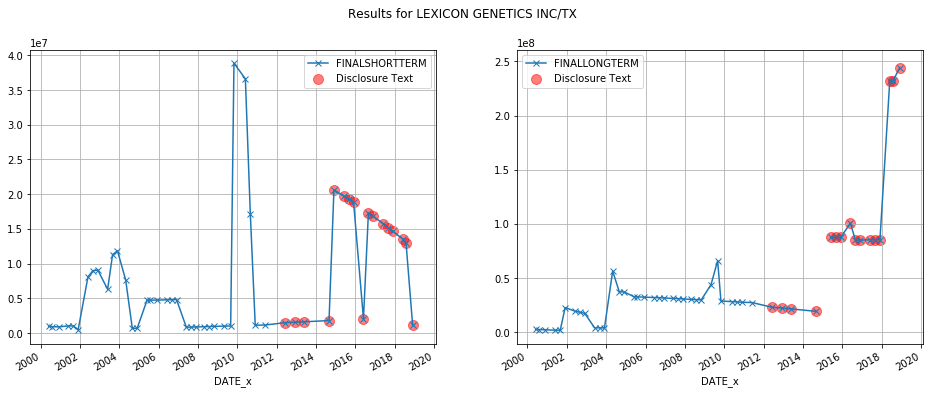

In [186]:
joined = getJoinedData(debt, disclosures, 1062822, fixScaling=True, threshold=1e5)
makeCompanyDebtPlots(joined)


In [133]:
viewFrame(joined)

,CIK,ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT,ACCOUNTSPAYABLECURRENT,ACCRUEDLIABILITIESCURRENT,CAPITALLEASEOBLIGATIONSCURRENT,DEBTCURRENT,EXTRACTCODE,FINALLONGTERM,FINALSHORTTERM,LIABILITIESCURRENT,LIABILITIESNONCURRENT,LIABILITIESOTHERTHANLONGTERMDEBTNONCURRENT,LONGTERMDEBTANDCAPITALLEASEOBLIGATIONSCURRENT,LONGTERMDEBTCURRENT,LONGTERMDEBTNONCURRENT,NAME,TEXT
DATE,,,,,,,,,,,,,,,,,
2000-05-31,1.062822e+09,1.970222e+09,NaN,NaN,78081000.0,9.576920e+08,TEXT,2.637783e+09,9.576920e+08,1.078458e+10,1.409314e+10,NaN,9.576920e+08,8.796110e+08,2.637783e+09,LEXICON GENETICS INC/TX,NaN
2000-07-31,1.062822e+09,1.666828e+09,NaN,NaN,21715000.0,9.013260e+08,TEXT,2.420455e+09,9.013260e+08,9.553766e+09,1.197422e+10,NaN,9.013260e+08,8.796110e+08,2.420455e+09,LEXICON GENETICS INC/TX,NaN
2000-11-30,1.062822e+09,2.328395e+09,NaN,NaN,0.0,8.741190e+08,TEXT,2.209705e+09,8.741190e+08,6.708853e+09,8.918558e+09,NaN,8.741190e+08,8.741190e+08,2.209705e+09,LEXICON GENETICS INC/TX,NaN
2001-05-31,1.062822e+09,5.546447e+09,2.522722e+09,3.023725e+09,NaN,1.012246e+09,TEXT,1.833982e+09,1.012246e+09,1.123051e+10,1.306449e+10,NaN,1.012246e+09,1.012246e+09,1.833982e+09,LEXICON GENETICS INC/TX,NaN
2001-08-31,1.062822e+09,5.546447e+09,2.522722e+09,3.023725e+09,NaN,1.012246e+09,TEXT,1.833982e+09,1.012246e+09,1.123051e+10,1.306449e+10,NaN,1.012246e+09,1.012246e+09,1.833982e+09,LEXICON GENETICS INC/TX,NaN
2001-11-30,1.062822e+09,7.732217e+09,4.126426e+09,3.605791e+09,103910000.0,4.678950e+08,TEXT,2.272398e+10,4.678950e+08,1.891507e+10,2.272398e+10,NaN,4.678950e+08,3.639850e+08,0.000000e+00,LEXICON GENETICS INC/TX,NaN
2002-05-31,1.062822e+09,8.081000e+06,4.046000e+06,4.035000e+06,NaN,NaN,TEXT,1.942400e+07,8.081000e+06,1.817400e+07,1.975300e+07,329000.0,NaN,NaN,NaN,LEXICON GENETICS INC/TX,NaN
2002-08-31,1.062822e+09,8.971000e+06,4.406000e+06,4.565000e+06,NaN,NaN,TEXT,1.838800e+07,8.971000e+06,1.838800e+07,1.870800e+07,320000.0,NaN,NaN,NaN,LEXICON GENETICS INC/TX,NaN
2002-11-30,1.062822e+09,9.052000e+06,4.270000e+06,4.782000e+06,NaN,NaN,TEXT,1.734600e+07,9.052000e+06,1.734600e+07,1.788600e+07,540000.0,NaN,NaN,NaN,LEXICON GENETICS INC/TX,NaN


In [71]:
viewDisclosure(joined)

2012-05-31
Debt Obligations Mortgage Loan. In April 2004, Lexicon obtained a $34.0 million mortgage on its facilities in The Woodlands, Texas. The mortgage loan has a ten-year term with a 20-year amortization and bears interest at a fixed rate of 8.23%. The mortgage had a principal balance outstanding of $24.5 million as of March 31, 2012. The fair value of Lexicon’s mortgage loan approximates its carrying value. The fair value of Lexicon’s mortgage loan is estimated using discounted cash flow analysis, based on the Company’s current incremental borrowing rate.

2012-11-30
Debt Obligations Mortgage Loan. In April 2004, Lexicon obtained a $34.0 million mortgage on its facilities in The Woodlands, Texas. The mortgage loan has a ten-year term with a 20-year amortization and bears interest at a fixed rate of 8.23%. The mortgage had a principal balance outstanding of $23.8 million as of September 30, 2012. The fair value of Lexicon’s mortgage loan approximates its carrying value. The fair v

## Company 2 Amicus Therapeutics CIK = 0001178879

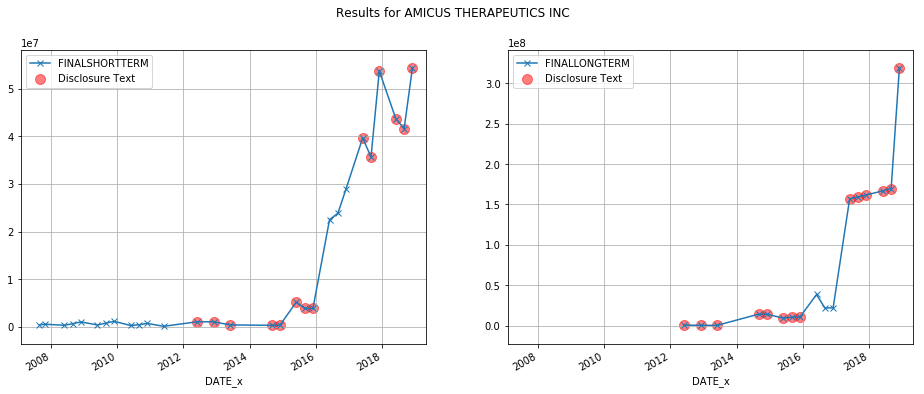

In [105]:
joined = getJoinedData(debt, disclosures, 1178879)
makeCompanyDebtPlots(joined)

In [107]:
viewFrame(joined)

,CIK,ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT,EXTRACTCODE,FINALLONGTERM,FINALSHORTTERM,LIABILITIESCURRENT,LIABILITIESNONCURRENT,NAME,TEXT
DATE,,,,,,,,,
2014-08-31,1541401,74807.0,HTML,1476781.0,74807.0,74807.0,1476781.0,"Empire State Realty Trust, Inc.",Debt Mortgage notes payable are collateralized...
2014-11-30,1541401,97413.0,HTML,1908913.0,97413.0,97413.0,1908913.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Sep...
2015-05-31,1541401,101797.0,HTML,1905282.0,101797.0,101797.0,1905282.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Mar...
2015-08-31,1541401,101674.0,HTML,1921418.0,101674.0,101674.0,1921418.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Jun...
2015-11-30,1541401,106699.0,HTML,1936157.0,106699.0,106699.0,1936157.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Sep...
2016-05-31,1541401,119104.0,HTML,1914396.0,119104.0,119104.0,1914396.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Mar...
2016-08-31,1541401,143296.0,HTML,1964885.0,143296.0,143296.0,1964885.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Jun...
2016-11-30,1541401,154573.0,HTML,1929730.0,154573.0,154573.0,1929730.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Sep...
2017-05-31,1541401,125910.0,HTML,1891250.0,125910.0,125910.0,1891250.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Mar...


In [77]:
viewDisclosure(joined)

2012-05-31
 Note 5. Short-Term Borrowings and Long-Term Debt In May 2009, the Company entered into a loan and security agreement with Silicon Valley Bank (SVB) that provides for up to $4 million of equipment financing through October 2012 (the “2009 Loan Agreement”). Borrowings under the agreement are collateralized by equipment purchased with the proceeds of the loan and bear interest at a fixed rate of approximately 9%. The 2009 Loan Agreement contains customary terms and conditions, including a financial covenant whereby the Company must maintain a minimum amount of liquidity measured at the end of each month where unrestricted cash, cash equivalents, and marketable securities, is greater than $20 million plus outstanding debt due to SVB. In addition, the Company committed to a second loan and security agreement with SVB in August 2011 (the “2011 Loan Agreement”) in order to finance certain capital expenditures made by the Company in connection with its move in March 2012 to new off

## Company 3 Empire State Realty Trust CIK = 0001541401

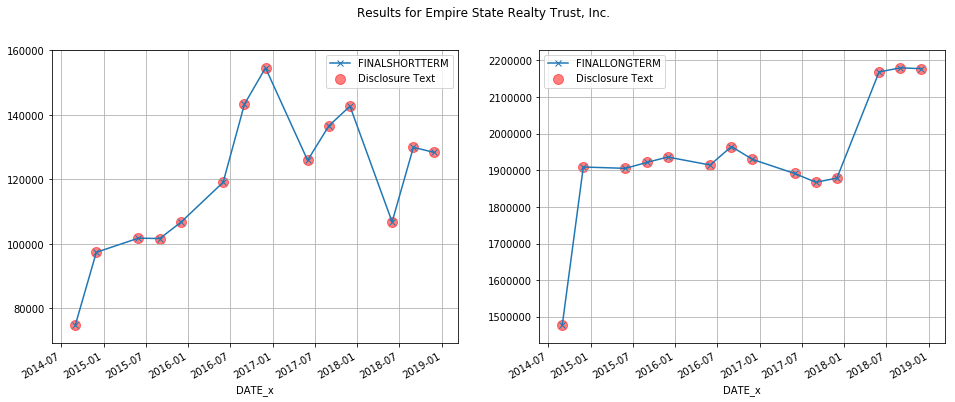

In [115]:
joined = getJoinedData(debt, disclosures, 1541401)
makeCompanyDebtPlots(joined)

In [80]:
viewFrame(joined)

,CIK,ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT,EXTRACTCODE,FINALLONGTERM,FINALSHORTTERM,LIABILITIESCURRENT,LIABILITIESNONCURRENT,NAME,TEXT
DATE,,,,,,,,,
2014-08-31,1541401,74807.0,HTML,1476781.0,74807000.0,74807.0,1476781.0,"Empire State Realty Trust, Inc.",Debt Mortgage notes payable are collateralized...
2014-11-30,1541401,97413.0,HTML,1908913.0,97413000.0,97413.0,1908913.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Sep...
2015-05-31,1541401,101797.0,HTML,1905282.0,101797.0,101797.0,1905282.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Mar...
2015-08-31,1541401,101674.0,HTML,1921418.0,101674.0,101674.0,1921418.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Jun...
2015-11-30,1541401,106699.0,HTML,1936157.0,106699.0,106699.0,1936157.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Sep...
2016-05-31,1541401,119104.0,HTML,1914396.0,119104.0,119104.0,1914396.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Mar...
2016-08-31,1541401,143296.0,HTML,1964885.0,143296.0,143296.0,1964885.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Jun...
2016-11-30,1541401,154573.0,HTML,1929730.0,154573.0,154573.0,1929730.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Sep...
2017-05-31,1541401,125910.0,HTML,1891250.0,125910.0,125910.0,1891250.0,"Empire State Realty Trust, Inc.",Debt Debt consisted of the following as of Mar...


In [108]:
viewDisclosure(joined)

2014-08-31
Debt Mortgage notes payable are collateralized by the following respective real estate properties and assignment of operating leases as of June 30, 2014 and December 31, 2013 (amounts in thousands): Principal Balance as of June 30, 2014 Principal Balance as of December 31, 2013 Stated Rate Effective Rate(1) Maturity Date(2) Mortgage debt collateralized by: Fixed rate debt 501 Seventh Avenue(3)$39,026 $— 5.80% 5.89% 8/1/2014(14) (Note 1)(3)— 1,037 (Note 2)(3)— 31,459 (Note 2)(3)— 6,889 1359 Broadway(4)44,276 — 6.04% 6.45% 8/1/2014(14) (first lien mortgage loan) (4)— 9,579 (second lien mortgage loan)(4)— 5,561 (second lien mortgage loan)(4)— 11,311 (second lien mortgage loan)(4)— 18,572 One Grand Central Place (first lien mortgage loan)70,578 71,723 5.34% 5.98% 11/5/2014 (second lien mortgage loan)14,724 14,884 7.00% 7.64% 11/5/2014 500 Mamaroneck Avenue32,260 32,620 5.41% 6.58% 1/1/2015 250 West 57th Street (first lien mortgage loan)25,194 25,621 5.33% 5.82% 1/5/2015 (second 

## Company 4 Wright Medical Group CIK = 0001492658

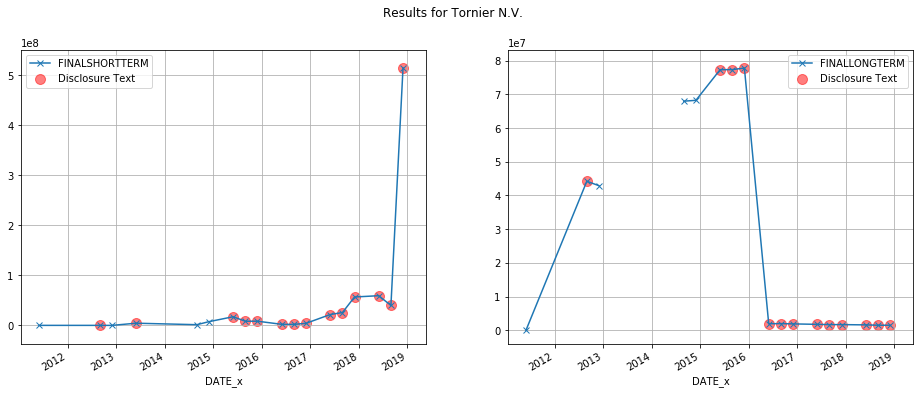

In [116]:
joined = getJoinedData(debt, disclosures, 1492658)
makeCompanyDebtPlots(joined)

In [111]:
viewFrame(joined)

,CIK,ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT,ACCOUNTSPAYABLECURRENT,ACCRUEDLIABILITIESCURRENT,CONVERTIBLENOTESPAYABLECURRENT,DEBTCURRENT,EXTRACTCODE,FINALLONGTERM,FINALSHORTTERM,LIABILITIESCURRENT,LIABILITIESNONCURRENT,LIABILITIESOTHERTHANLONGTERMDEBTNONCURRENT,LONGTERMDEBTANDCAPITALLEASEOBLIGATIONS,LONGTERMDEBTANDCAPITALLEASEOBLIGATIONSCURRENT,LONGTERMDEBTCURRENT,LONGTERMDEBTNONCURRENT,LONGTERMNOTESANDLOANS,LONGTERMNOTESPAYABLE,NAME,NOTESANDLOANSPAYABLECURRENT,NOTESPAYABLECURRENT,OTHERLONGTERMDEBTCURRENT,OTHERLONGTERMDEBTNONCURRENT,SECUREDLONGTERMDEBT,SHORTTERMBORROWINGS,TEXT
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-31,1.492658e+09,1674000.0,13180000.0,37223000.0,NaN,16367000.0,HTML,25562000.0,1.636700e+07,6.779600e+07,120895000.0,3964000.0,NaN,NaN,NaN,25562000.0,NaN,NaN,Tornier N.V.,NaN,NaN,NaN,25562000.0,NaN,NaN,NaN
2012-08-31,1.492658e+06,46465000.0,12020000.0,34445000.0,NaN,18011000.0,XBRL,44200000.0,1.801100e-02,6.547400e+07,NaN,NaN,NaN,39911000.0,39911000.0,44200000.0,NaN,NaN,Tornier N.V.,NaN,NaN,22262000.0,21900000.0,22300000.0,1.801100e-02,6. Instruments Instruments included in long-te...
2012-11-30,1.492658e+06,48383000.0,10044000.0,38339000.0,NaN,25966000.0,XBRL,42884000.0,2.596600e-02,7.498400e+07,NaN,NaN,NaN,47050000.0,47050000.0,42884000.0,NaN,NaN,Tornier N.V.,NaN,NaN,21790000.0,21084000.0,21800000.0,2.596600e-02,NaN
2013-05-31,1.492658e+06,63309000.0,15297000.0,48012000.0,NaN,4337000.0,XBRL,NaN,4.337000e+06,7.602800e+07,NaN,NaN,NaN,117698000.0,117698000.0,NaN,NaN,NaN,Tornier N.V.,NaN,NaN,111106000.0,NaN,NaN,4.337000e+06,\n9. Debt The following table\nprovides a summ...
2014-08-31,1.492658e+06,74269000.0,21149000.0,53120000.0,NaN,1364000.0,XBRL,67948000.0,1.364000e+06,8.566800e+07,NaN,NaN,NaN,NaN,NaN,67948000.0,NaN,NaN,Tornier N.V.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30,1.492658e+06,68076000.0,14269000.0,53807000.0,NaN,7408000.0,XBRL,68201000.0,7.408000e+06,7.856100e+07,NaN,NaN,NaN,NaN,NaN,68201000.0,NaN,NaN,Tornier N.V.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,1.492658e+06,73767000.0,16592000.0,57175000.0,NaN,17255000.0,XBRL,77286000.0,1.725500e+07,9.429200e+07,NaN,NaN,NaN,NaN,NaN,77286000.0,2000000.0,2000000.0,Tornier N.V.,NaN,NaN,NaN,NaN,NaN,NaN,8. Debt A summary of debt is as follows (in t...
2015-08-31,1.492658e+06,73864000.0,20630000.0,53234000.0,NaN,8264000.0,XBRL,77308000.0,8.264000e+06,8.487500e+07,NaN,NaN,NaN,NaN,NaN,77308000.0,2000000.0,2000000.0,Tornier N.V.,NaN,NaN,NaN,NaN,NaN,NaN,8. Debt A summary of debt is as follows (in t...
2015-11-30,1.492658e+06,72211000.0,15306000.0,56905000.0,NaN,8354000.0,XBRL,77774000.0,8.354000e+06,8.270600e+07,NaN,NaN,NaN,NaN,NaN,77774000.0,2000000.0,2000000.0,Wright Medical Group N.V.,NaN,NaN,NaN,NaN,NaN,NaN,8. Debt A summary of debt is as follows (in t...


In [117]:
viewDisclosure(joined)

2012-08-31
6. Instruments Instruments included in long-term assets on the consolidated balance sheets consist of the following (in thousands): July 1,2012 January 1,2012 Instruments $
77,631 $
72,971 Instruments in process 18,403 18,024 Accumulated depreciation (46,702
) (41,648
) Instruments, net $
49,332 $
49,347 The Company recorded an impairment of $0.3 million for the six months ended July 1, 2012 related to instrument set components that were scrapped as a result of a revision to an existing product line. 

2013-05-31

9. Debt The following table
provides a summary of the components of debt (in
thousands): March 31,
2013 December 30,
2012 Lines of credit and
overdraft arrangements $
1,000 $
1,000 Mortgages 3,454 3,719 Term debt 111,106 113,135 Shareholder debt 2,138 2,198 Total debt 117,698 120,052 Less current
portion (4,337
) (4,595
) Long-term debt $
113,361 $
115,457 Lines of
Credit On October 4, 2012,
the Company and its U.S. operating subsidiary, Tornier, Inc.
(Tornier USA)

## Company 5 Heritage Insurance Holdings CIK = 0001598665

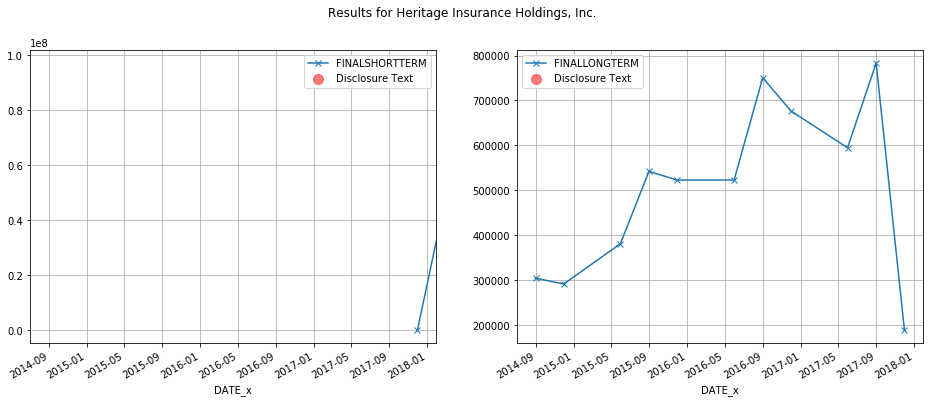

In [155]:
joined = getJoinedData(debt, disclosures, 1598665)
makeCompanyDebtPlots(joined)

In [156]:
viewFrame(joined)

,CIK,ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT,BANKOVERDRAFTS,DEBTCURRENT,EXTRACTCODE,FINALLONGTERM,FINALSHORTTERM,LIABILITIESCURRENT,LIABILITIESNONCURRENT,LONGTERMDEBTNONCURRENT,NAME,SHORTTERMBORROWINGS,Quarter
DATE,,,,,,,,,,,,,
2014-08-31,1598665,NaN,NaN,NaN,HTML,304224.0,NaN,NaN,304224.0,NaN,"Heritage Insurance Holdings, Inc.",NaN,20143
2014-11-30,1598665,NaN,NaN,NaN,HTML,291291.0,NaN,NaN,291291.0,NaN,"Heritage Insurance Holdings, Inc.",NaN,20144
2015-05-31,1598665,NaN,NaN,NaN,HTML,380843.0,NaN,NaN,380843.0,NaN,"Heritage Insurance Holdings, Inc.",NaN,20152
2015-08-31,1598665,NaN,NaN,NaN,HTML,542025.0,NaN,NaN,542025.0,NaN,"Heritage Insurance Holdings, Inc.",NaN,20153
2015-11-30,1598665,NaN,NaN,NaN,HTML,522644.0,NaN,NaN,522644.0,NaN,"Heritage Insurance Holdings, Inc.",NaN,20154
2016-05-31,1598665,NaN,NaN,NaN,HTML,522798.0,NaN,NaN,522798.0,NaN,"Heritage Insurance Holdings, Inc.",NaN,20162
2016-08-31,1598665,NaN,NaN,NaN,HTML,750598.0,NaN,NaN,750598.0,NaN,"Heritage Insurance Holdings, Inc.",NaN,20163
2016-11-30,1598665,NaN,NaN,NaN,HTML,676470.0,NaN,NaN,676470.0,NaN,"Heritage Insurance Holdings, Inc.",NaN,20164
2017-05-31,1598665,NaN,NaN,NaN,HTML,594573.0,NaN,NaN,594573.0,NaN,"Heritage Insurance Holdings, Inc.",NaN,20172


## Company 6 Cheasapeake Energy Corporation CIK = 0000895126

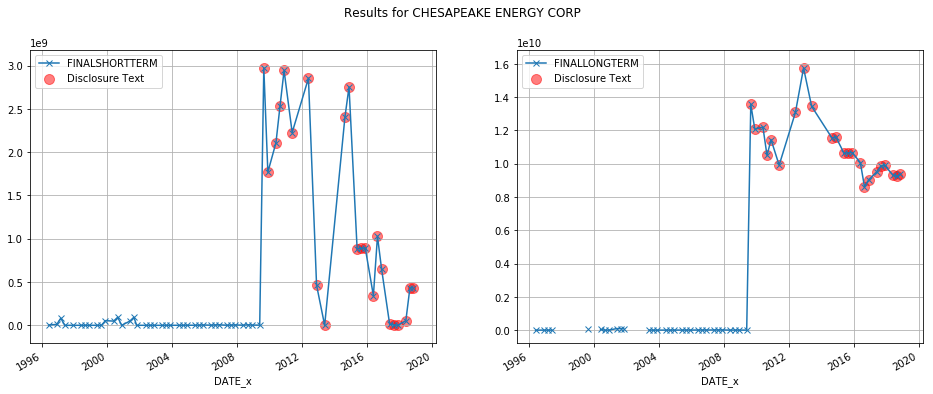

In [192]:
joined = getJoinedData(debt, disclosures, 895126, fixScaling=True,)
makeCompanyDebtPlots(joined)

In [158]:
viewFrame(joined)

,CIK,ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT,ACCOUNTSPAYABLECURRENT,ACCRUEDLIABILITIESCURRENT,DEBTCURRENT,EXTRACTCODE,FINALLONGTERM,FINALSHORTTERM,LIABILITIESCURRENT,LIABILITIESNONCURRENT,LIABILITIESOTHERTHANLONGTERMDEBTNONCURRENT,LONGTERMDEBTANDCAPITALLEASEOBLIGATIONSCURRENT,LONGTERMDEBTCURRENT,LONGTERMDEBTNONCURRENT,NAME,NOTESANDLOANSPAYABLECURRENT,NOTESPAYABLECURRENT,OTHERACCRUEDLIABILITIESCURRENT,OTHERLIABILITIESCURRENT,OTHERLONGTERMDEBTNONCURRENT,TEXT
DATE,,,,,,,,,,,,,,,,,,,,,
1996-05-31,895126,3.780000e+05,6.249100e+07,8.048000e+06,3.267000e+06,TEXT,1.840840e+05,3.267000e+06,1.171280e+05,NaN,NaN,3.267000e+06,3.267000e+06,1.840840e+05,CHESAPEAKE ENERGY CORP,NaN,NaN,378000.0,NaN,NaN,NaN
1996-11-30,895126,7.081500e+07,5.694600e+07,1.386900e+07,1.064200e+07,TEXT,2.773230e+05,1.064200e+07,1.096570e+05,NaN,NaN,1.064200e+07,1.064200e+07,2.773230e+05,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1997-02-28,895126,8.240000e+07,7.225600e+07,1.014400e+07,NaN,TEXT,2.201490e+05,8.240000e+07,1.270920e+05,NaN,NaN,NaN,NaN,2.201490e+05,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-31,895126,1.175840e+05,8.669100e+07,1.571600e+07,1.194950e+05,TEXT,3.200000e+04,1.194950e+05,1.413140e+05,NaN,NaN,1.194950e+05,1.194950e+05,3.200000e+04,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,895126,1.017760e+05,8.173100e+07,1.853200e+07,0.000000e+00,TEXT,NaN,0.000000e+00,1.239490e+05,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1998-05-31,895126,1.196790e+05,1.001350e+05,5.351900e+07,1.200000e+05,TEXT,NaN,1.200000e+05,1.796740e+05,NaN,NaN,1.200000e+05,1.200000e+05,0.000000e+00,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1998-08-31,895126,8.837000e+07,5.855900e+07,4.990600e+07,4.741660e+05,TEXT,NaN,4.741660e+05,1.300800e+05,NaN,NaN,4.741660e+05,4.741660e+05,0.000000e+00,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1998-11-30,895126,8.200600e+07,4.315000e+07,5.550500e+07,4.741660e+05,TEXT,NaN,4.741660e+05,1.193000e+05,NaN,NaN,4.741660e+05,4.741660e+05,0.000000e+00,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1999-05-31,895126,5.716900e+07,2.648200e+07,4.637600e+07,0.000000e+00,TEXT,NaN,0.000000e+00,1.141100e+05,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,CHESAPEAKE ENERGY CORP,25000000.0,25000000.0,NaN,NaN,NaN,NaN


## Company 7 International Business Machines Corporation CIK = 0000051143

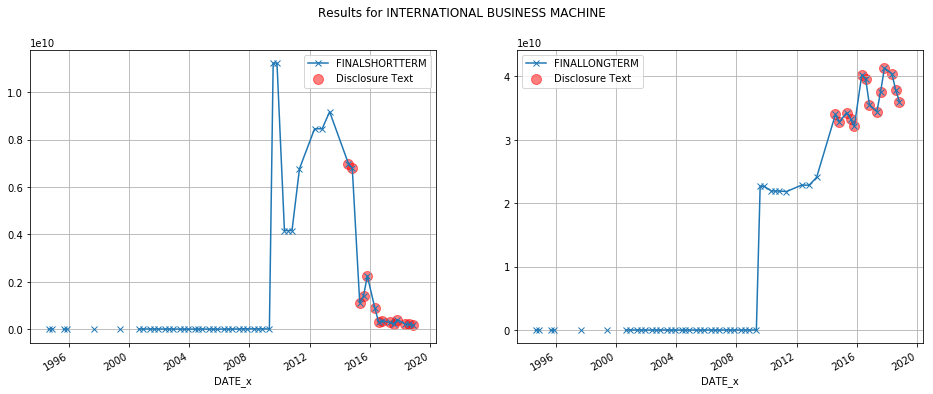

In [173]:
joined = getJoinedData(debt, disclosures, 51143, fixScaling=True)
makeCompanyDebtPlots(joined)

In [193]:
viewFrame(joined)

,CIK,ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT,ACCOUNTSPAYABLECURRENT,ACCRUEDLIABILITIESCURRENT,DEBTCURRENT,EXTRACTCODE,FINALLONGTERM,FINALSHORTTERM,LIABILITIESCURRENT,LIABILITIESNONCURRENT,LIABILITIESOTHERTHANLONGTERMDEBTNONCURRENT,LONGTERMDEBTANDCAPITALLEASEOBLIGATIONSCURRENT,LONGTERMDEBTCURRENT,LONGTERMDEBTNONCURRENT,NAME,NOTESANDLOANSPAYABLECURRENT,NOTESPAYABLECURRENT,OTHERACCRUEDLIABILITIESCURRENT,OTHERLIABILITIESCURRENT,OTHERLONGTERMDEBTNONCURRENT,TEXT
DATE,,,,,,,,,,,,,,,,,,,,,
1996-05-31,895126,3.780000e+05,6.249100e+07,8.048000e+06,3.267000e+06,TEXT,1.840840e+05,3.267000e+06,1.171280e+05,NaN,NaN,3.267000e+06,3.267000e+06,1.840840e+05,CHESAPEAKE ENERGY CORP,NaN,NaN,378000.0,NaN,NaN,NaN
1996-11-30,895126,7.081500e+07,5.694600e+07,1.386900e+07,1.064200e+07,TEXT,2.773230e+05,1.064200e+07,1.096570e+05,NaN,NaN,1.064200e+07,1.064200e+07,2.773230e+05,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1997-02-28,895126,8.240000e+07,7.225600e+07,1.014400e+07,NaN,TEXT,2.201490e+05,8.240000e+07,1.270920e+05,NaN,NaN,NaN,NaN,2.201490e+05,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-31,895126,1.175840e+05,8.669100e+07,1.571600e+07,1.194950e+05,TEXT,3.200000e+04,1.194950e+05,1.413140e+05,NaN,NaN,1.194950e+05,1.194950e+05,3.200000e+04,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,895126,1.017760e+05,8.173100e+07,1.853200e+07,0.000000e+00,TEXT,NaN,0.000000e+00,1.239490e+05,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1998-05-31,895126,1.196790e+05,1.001350e+05,5.351900e+07,1.200000e+05,TEXT,NaN,1.200000e+05,1.796740e+05,NaN,NaN,1.200000e+05,1.200000e+05,0.000000e+00,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1998-08-31,895126,8.837000e+07,5.855900e+07,4.990600e+07,4.741660e+05,TEXT,NaN,4.741660e+05,1.300800e+05,NaN,NaN,4.741660e+05,4.741660e+05,0.000000e+00,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1998-11-30,895126,8.200600e+07,4.315000e+07,5.550500e+07,4.741660e+05,TEXT,NaN,4.741660e+05,1.193000e+05,NaN,NaN,4.741660e+05,4.741660e+05,0.000000e+00,CHESAPEAKE ENERGY CORP,NaN,NaN,NaN,NaN,NaN,NaN
1999-05-31,895126,5.716900e+07,2.648200e+07,4.637600e+07,0.000000e+00,TEXT,NaN,0.000000e+00,1.141100e+05,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,CHESAPEAKE ENERGY CORP,25000000.0,25000000.0,NaN,NaN,NaN,NaN


In [194]:
viewDisclosure(joined)

2009-08-31
 6.
Senior Notes and Revolving Bank Credit
Facilities Our total debt consisted of
the following: June 30,
2009 December 31,
2008 (Adjusted) ($ in millions) 7.5% Senior Notes due 2013 $
364 $
364 7.625% Senior Notes due 2013 500 500 7.0% Senior Notes due 2014 300 300 7.5% Senior Notes due 2014 300 300 6.375% Senior Notes due 2015 600 600 9.5% Senior Notes due 2015 1,425 — 6.625% Senior Notes due 2016 600 600 6.875% Senior Notes due 2016 670 670 6.25% Euro-denominated
Senior Notes due 2017(a) 841 835 6.5% Senior Notes due 2017 1,100 1,100 6.25% Senior Notes due 2018 600 600 7.25% Senior Notes due 2018 800 800 6.875% Senior Notes due 2020 500 500 2.75% Contingent
Convertible Senior Notes due 2035(b) 451 451 2.5% Contingent
Convertible Senior Notes due 2037(b) 1,378 1,378 2.25% Contingent
Convertible Senior Notes due 2038(b) 1,041 1,126 Revolving bank credit
facility 2,834 3,474 Midstream revolving bank credit
facility 297 460 Discount on senior
notes(c) (1,072
) (1,094
) Intere

## Company 8 Apple Inc CIK = 0000320193

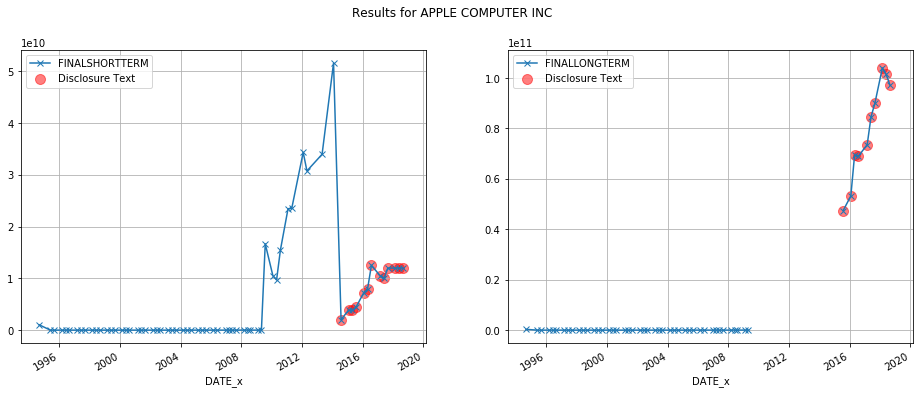

In [195]:
joined = getJoinedData(debt, disclosures, 320193, fixScaling=True, threshold=1e7)
makeCompanyDebtPlots(joined)

In [196]:
viewFrame(joined)

,CIK,ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT,ACCOUNTSPAYABLECURRENT,ACCRUEDLIABILITIESCURRENT,COMMERCIALPAPER,DEBTCURRENT,EXTRACTCODE,FINALLONGTERM,FINALSHORTTERM,LIABILITIESCURRENT,LIABILITIESNONCURRENT,LIABILITIESOTHERTHANLONGTERMDEBTNONCURRENT,LONGTERMDEBTANDCAPITALLEASEOBLIGATIONSCURRENT,LONGTERMDEBTCURRENT,LONGTERMDEBTNONCURRENT,NAME,NOTESANDLOANSPAYABLECURRENT,NOTESPAYABLECURRENT,NOTESPAYABLETOBANKCURRENT,OTHERACCRUEDLIABILITIESCURRENT,SHORTTERMBORROWINGS,TEXT
DATE,,,,,,,,,,,,,,,,,,,,,,
1994-08-31,320193000,1.041335e+09,6.960320e+08,NaN,NaN,NaN,TEXT,3.048150e+08,1.041335e+09,1.917487e+09,NaN,NaN,NaN,NaN,3.048150e+08,APPLE COMPUTER INC,NaN,NaN,NaN,3.453030e+08,NaN,NaN
1995-05-31,320193000,1.270000e+06,8.540000e+05,NaN,NaN,6.270000e+05,TEXT,3.040000e+05,6.270000e+05,2.243000e+06,NaN,NaN,NaN,NaN,3.040000e+05,APPLE COMPUTER INC,NaN,NaN,NaN,4.160000e+05,6.270000e+05,NaN
1995-08-31,320193000,1.438000e+06,1.048000e+06,NaN,NaN,4.060000e+05,TEXT,3.030000e+05,4.060000e+05,2.178000e+06,NaN,NaN,NaN,NaN,3.030000e+05,APPLE COMPUTER INC,NaN,NaN,NaN,3.900000e+05,4.060000e+05,NaN
1996-02-29,320193000,1.431000e+06,1.431000e+06,NaN,NaN,4.980000e+05,TEXT,3.040000e+05,4.980000e+05,2.705000e+06,NaN,NaN,NaN,NaN,3.040000e+05,APPLE COMPUTER INC,NaN,NaN,NaN,NaN,4.980000e+05,NaN
1996-05-31,320193000,1.304000e+06,8.170000e+05,NaN,NaN,3.520000e+05,TEXT,3.030000e+05,3.520000e+05,2.273000e+06,NaN,NaN,NaN,NaN,3.030000e+05,APPLE COMPUTER INC,NaN,NaN,NaN,4.870000e+05,3.520000e+05,NaN
1996-08-31,320193000,7.620000e+05,7.620000e+05,NaN,NaN,1.870000e+05,TEXT,9.490000e+05,1.870000e+05,1.926000e+06,NaN,NaN,NaN,NaN,9.490000e+05,APPLE COMPUTER INC,NaN,NaN,NaN,NaN,1.870000e+05,NaN
1997-02-28,320193000,8.380000e+05,8.200000e+05,NaN,NaN,NaN,TEXT,9.500000e+05,8.380000e+05,2.044000e+06,NaN,NaN,NaN,NaN,9.500000e+05,APPLE COMPUTER INC,NaN,NaN,NaN,1.800000e+04,NaN,NaN
1997-05-31,320193000,8.400000e+05,8.400000e+05,NaN,NaN,NaN,TEXT,9.520000e+05,8.400000e+05,2.011000e+06,NaN,NaN,NaN,NaN,9.520000e+05,APPLE COMPUTER INC,NaN,NaN,NaN,NaN,NaN,NaN
1997-08-31,320193000,1.093000e+06,8.120000e+05,NaN,NaN,NaN,TEXT,9.510000e+05,1.093000e+06,1.910000e+06,NaN,NaN,NaN,NaN,9.510000e+05,APPLE COMPUTER INC,NaN,NaN,NaN,2.810000e+05,NaN,NaN


In [197]:
viewDisclosure(joined)

2014-07-31

Note 6 – Debt
Commercial Paper In April 2014, the Board of Directors authorized the Company to issue unsecured short-term promissory notes (“Commercial Paper”) pursuant to a commercial paper program. The Company intends to use net proceeds from the commercial paper program for general corporate purposes, including dividends and share repurchases. As of June 28, 2014, the Company had $2.0 billion of Commercial Paper outstanding, with a weighted average interest rate of 0.09% and maturities generally less than nine months.
Long-Term Debt In the third quarter of 2014 and 2013, the Company issued $12.0 billion and $17.0 billion of long-term debt, respectively. The debt issuances included floating- and fixed-rate notes with varying maturities for an aggregate principal amount of $29.0 billion (collectively the “Notes”). The Notes are senior unsecured obligations, and interest is payable in arrears, quarterly for the floating-rate notes and semi-annually for the fixed-rate notes.

## Company 9 Hovnanian Enterprises Inc CIK = 0000357294

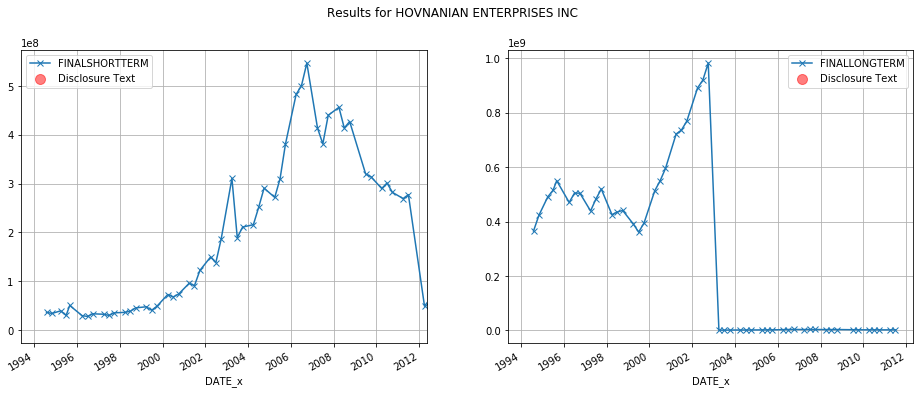

In [198]:
joined = getJoinedData(debt, disclosures, 357294, fixScaling=True, scaleBy=1e3)
makeCompanyDebtPlots(joined)

In [201]:
viewFrame(joined)

In [202]:
viewDisclosure(joined)

## Company 10 Wyndham Destinations, Inc CIK = 1361658

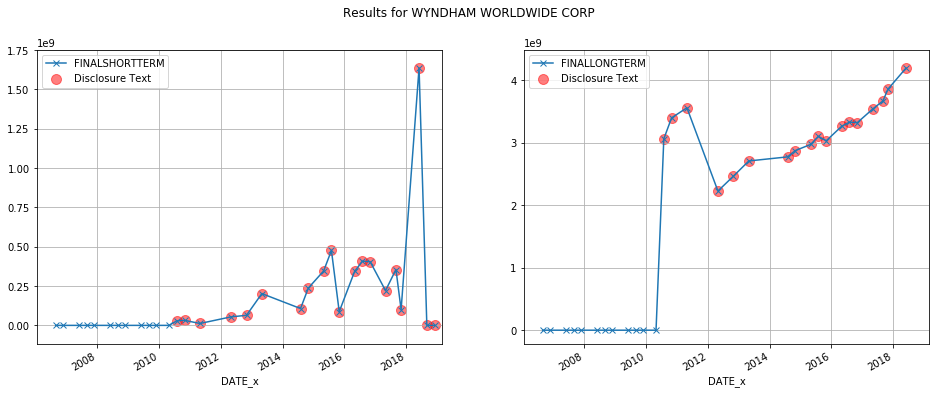

In [205]:
joined = getJoinedData(debt, disclosures, 1361658)
makeCompanyDebtPlots(joined)

In [206]:
viewFrame(joined)

,CIK,ACCOUNTSPAYABLEANDACCRUEDLIABILITIESCURRENT,ACCOUNTSPAYABLECURRENT,BRIDGELOAN,COMMERCIALPAPER,CONVERTIBLENOTESPAYABLECURRENT,DEBTCURRENT,EXTRACTCODE,FINALLONGTERM,FINALSHORTTERM,LIABILITIESCURRENT,LIABILITIESNONCURRENT,LIABILITIESOTHERTHANLONGTERMDEBTNONCURRENT,LONGTERMDEBTANDCAPITALLEASEOBLIGATIONSCURRENT,LONGTERMDEBTCURRENT,LONGTERMDEBTNONCURRENT,NAME,NOTESANDLOANSPAYABLECURRENT,NOTESPAYABLECURRENT,OTHERACCRUEDLIABILITIESCURRENT,OTHERLIABILITIESCURRENT,OTHERLONGTERMDEBTNONCURRENT,SECUREDDEBTCURRENT,SECUREDLONGTERMDEBT,SHORTTERMBORROWINGS,TEXT
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-08-31,1361658,79.0,344.0,NaN,NaN,NaN,NaN,HTML,6.002000e+03,7.900000e+01,3.151000e+03,6069.0,67.0,NaN,NaN,NaN,WYNDHAM WORLDWIDE CORP,NaN,NaN,484.0,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-30,1361658,242.0,240.0,NaN,NaN,NaN,143.0,HTML,1.021000e+03,1.430000e+02,2.047000e+03,5506.0,65.0,143.0,143.0,1.021000e+03,WYNDHAM WORLDWIDE CORP,NaN,NaN,665.0,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-31,1361658,135.0,466.0,NaN,NaN,NaN,123.0,HTML,1.296000e+03,1.230000e+02,2.145000e+03,6358.0,122.0,123.0,123.0,1.296000e+03,WYNDHAM WORLDWIDE CORP,NaN,NaN,607.0,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-31,1361658,55.0,401.0,NaN,NaN,NaN,140.0,HTML,1.463000e+03,1.400000e+02,2.183000e+03,6694.0,106.0,140.0,140.0,1.463000e+03,WYNDHAM WORLDWIDE CORP,NaN,NaN,654.0,NaN,NaN,NaN,NaN,NaN,NaN
2007-11-30,1361658,118.0,342.0,NaN,NaN,NaN,159.0,HTML,1.386000e+03,1.590000e+02,2.257000e+03,6792.0,124.0,159.0,159.0,1.386000e+03,WYNDHAM WORLDWIDE CORP,NaN,NaN,733.0,NaN,NaN,NaN,NaN,NaN,NaN
2008-05-31,1361658,69.0,467.0,NaN,NaN,NaN,193.0,HTML,1.359000e+03,1.930000e+02,2.461000e+03,7285.0,164.0,193.0,193.0,1.359000e+03,WYNDHAM WORLDWIDE CORP,NaN,NaN,665.0,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-31,1361658,1.0,415.0,NaN,NaN,NaN,207.0,HTML,1.406000e+03,2.070000e+02,2.463000e+03,7292.0,141.0,207.0,207.0,1.406000e+03,WYNDHAM WORLDWIDE CORP,NaN,NaN,661.0,NaN,NaN,NaN,NaN,NaN,NaN
2008-11-30,1361658,55.0,273.0,NaN,NaN,NaN,182.0,HTML,1.547000e+03,1.820000e+02,2.307000e+03,7244.0,130.0,182.0,182.0,1.547000e+03,WYNDHAM WORLDWIDE CORP,NaN,NaN,694.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-31,1361658,112.0,384.0,NaN,NaN,NaN,166.0,HTML,1.747000e+03,1.660000e+02,2.194000e+03,7065.0,198.0,166.0,166.0,1.747000e+03,WYNDHAM WORLDWIDE CORP,NaN,NaN,614.0,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
viewDisclosure(joined)

2010-07-31
 7. Long-Term Debt and Borrowing Arrangements The Company's indebtedness consisted of: June 30, December 31, 2010 2009 Securitized vacation ownership debt: (a) Term notes $ 1,255 $ 1,112 Bank conduit facility (b) 291 395 Total securitized vacation ownership debt 1,546 1,507 Less: Current portion of securitized vacation ownership debt 248 209 Long-term securitized vacation ownership debt $ 1,298 $ 1,298 Long-term debt: 6.00% senior unsecured notes (due December 2016) (c) $ 798 $ 797 Term loan (d) — 300 Revolving credit facility (due October 2013) (e) — — 9.875% senior unsecured notes (due May 2014) (f) 239 238 3.50% convertible notes (due May 2012) (g) 362 367 7.375% senior unsecured notes (due March 2020) (h) 247 — Vacation ownership bank borrowings (i) — 153 Vacation rentals capital leases(j) 110 133 Other 36 27 Total long-term debt 1,792 2,015 Less: Current portion of long-term debt 29 175 Long-term debt $ 1,763 $ 1,840 ­ ­ (a) Represents debt that is securitized through b